In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [12]:
import yfinance as yf

df = yf.download("RELIANCE.NS", period="8y", interval="1d")
csv_path = "/content/drive/MyDrive/Colab_Stock/RELIANCE_8y(17-25).csv"
df.to_csv(csv_path)
df

/tmp/ipython-input-12-1644694423.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("RELIANCE.NS", period="8y", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2017-06-30,314.418915,317.244108,313.291094,317.152975,7814271
2017-07-03,314.658142,317.768173,312.368372,316.287196,9195278
2017-07-04,323.976776,325.150163,316.469472,316.697305,18816782
2017-07-05,328.693085,329.786715,324.443857,325.685594,27209010
2017-07-06,328.670319,330.367722,327.633631,330.071509,13590313
...,...,...,...,...,...
2025-06-24,1450.800049,1475.000000,1443.099976,1465.000000,16402744
2025-06-25,1467.300049,1472.400024,1460.500000,1464.000000,7525851


In [13]:
df_clean = df[['Open', 'High', 'Close']]
# Date already comes in datetime format and as index
df_clean

#print(df_clean.index)

#df_clean.loc["2020-03-23"] # to get a particular date's data

Price,Open,High,Close
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,
2017-06-30,317.152975,317.244108,314.418915
2017-07-03,316.287196,317.768173,314.658142
2017-07-04,316.697305,325.150163,323.976776
2017-07-05,325.685594,329.786715,328.693085
2017-07-06,330.071509,330.367722,328.670319
...,...,...,...
2025-06-24,1465.000000,1475.000000,1450.800049
2025-06-25,1464.000000,1472.400024,1467.300049


In [55]:
%%writefile -a /content/drive/MyDrive/Colab_Stock/utils.py

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

def plot_graph(df_clean):

    # Closing prices for 8 years
    plt.figure(figsize=(12,5))
    plt.plot(df_clean.index, df_clean['Close'], color='blue')
    plt.title("Stock Prices of Last 8 Years")
    plt.xlabel("Date")
    plt.ylabel("Closing Prices")
    plt.show()

    print("\n")

    # Trend, Seasonality, Residual Plot
    close_series = df_clean["Close"].dropna()
    decomposition = seasonal_decompose(close_series, model='multiplicative', period=252)

    plt.figure(figsize=(12,8))

    plt.subplot(3, 1, 1)
    plt.plot(decomposition.trend, color='black')
    plt.title("Trend")

    print("\n\n")

    plt.subplot(3, 1, 2)
    plt.plot(decomposition.seasonal, color='orange')
    plt.title("Seasonality")

    print("\n\n")

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid, color='red')
    plt.title("Residual (Noise)")
    plt.show()

    print("\n\n")
    # PACF Plot
    plt.figure(figsize=(12, 5))
    plot_pacf(close_series, lags=30, method='ywm')
    plt.title("Partial Autocorrelation Function (PACF)")
    plt.show()

    print("\n\n\n")

    # 20-day moving average
    df_clean['MA_20'] = df_clean['Close'].rolling(window=20).mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df_clean['Close'], label='Close Price', linewidth=1.5)
    plt.plot(df_clean['MA_20'], label='20-Day Moving Average', color='orange', linewidth=2)
    plt.title('Close Price vs 20-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Writing /content/drive/MyDrive/Colab_Stock/utils.py


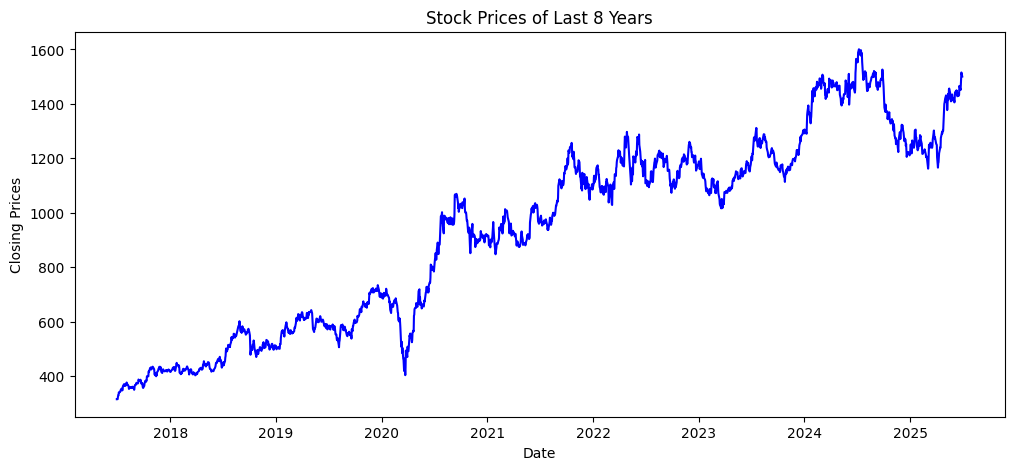

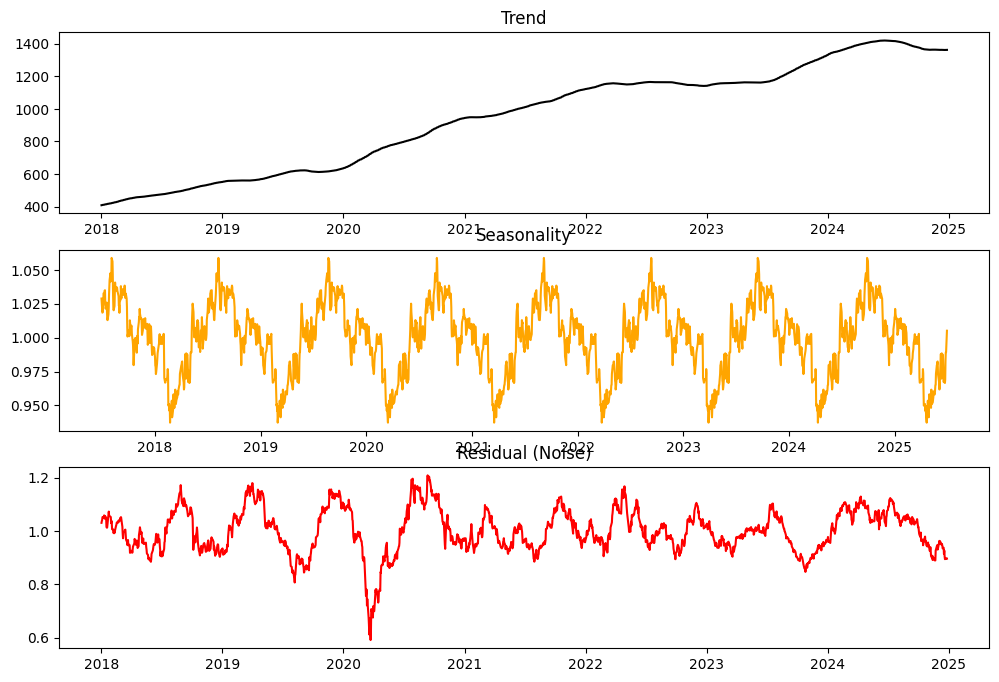

<Figure size 1200x500 with 0 Axes>

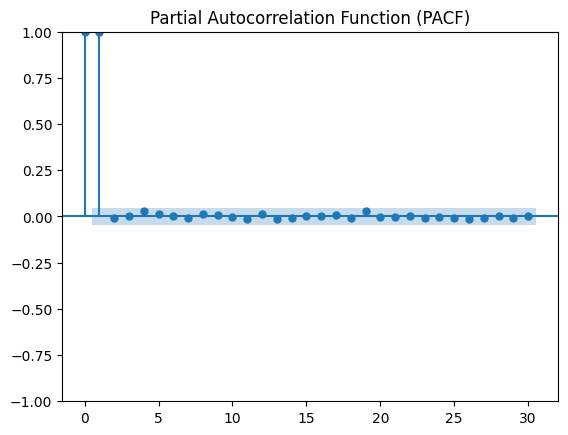

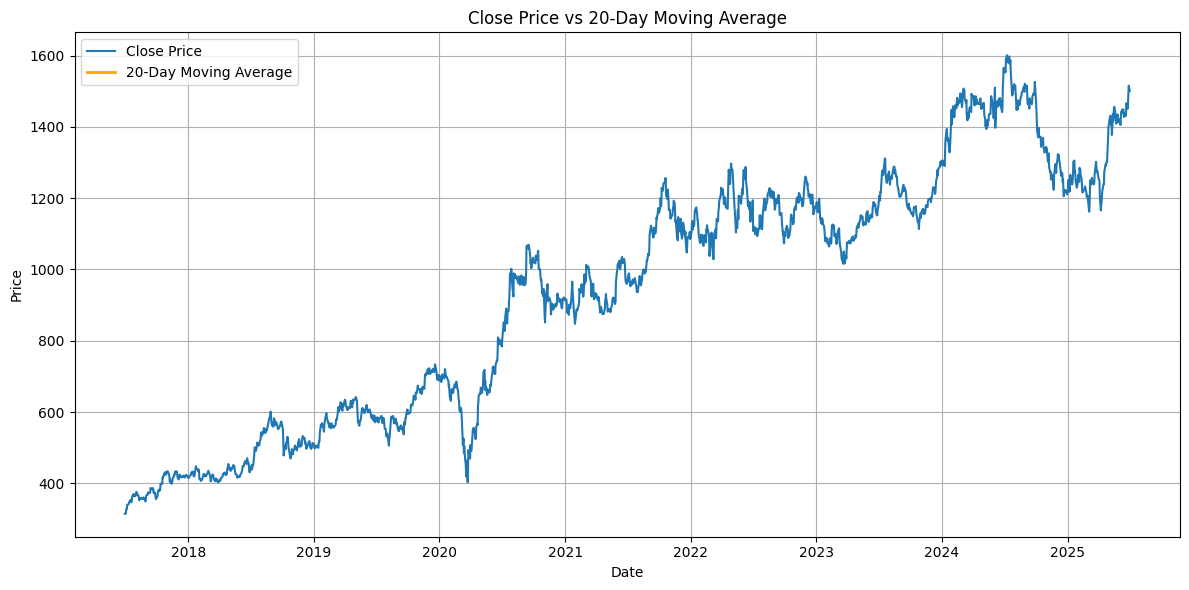

In [54]:
plot_graph(df_clean)

In [56]:
%%writefile -a /content/drive/MyDrive/Colab_Stock/utils.py

# training data, validation data and test data

# We will try to change the ratios if accuaracy not satisfactory for model training.
import pandas as pd
import numpy as np

def split_df_clean(df_clean, train_ratio=0.875, val_ratio=0.0625):

    df_clean = df_clean[['Open', 'High', 'Close']].dropna().copy()

    total_len = len(df_clean)
    train_end = int(total_len * train_ratio)
    val_end = train_end + int(total_len * val_ratio)

    df_train = df_clean.iloc[:train_end]
    df_val   = df_clean.iloc[train_end:val_end]
    df_test  = df_clean.iloc[val_end:]

    return df_train, df_val, df_test

Appending to /content/drive/MyDrive/Colab_Stock/utils.py


In [57]:
%%writefile -a /content/drive/MyDrive/Colab_Stock/utils.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_stock_data_lstm(df_split, lags=30, scaler=None, is_train=True):
    df_split = df_split[['Open', 'High', 'Close']].dropna().copy()

    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df_split)
    else:
        scaled_values = scaler.transform(df_split)

    df_scaled = pd.DataFrame(scaled_values, columns=['Open', 'High', 'Close'], index=df_split.index)

    X, y = [], []
    for i in range(lags, len(df_scaled)):
        X.append(df_scaled.iloc[i-lags:i].values)
        y.append(df_scaled.iloc[i]['Close'])

    return np.array(X), np.array(y), scaler

Appending to /content/drive/MyDrive/Colab_Stock/utils.py


In [47]:
df_train, df_val, df_test = split_df_clean(df_clean)

X_train, y_train, scaler = preprocess_stock_data_lstm(df_train, lags=30, scaler=None, is_train=True)
X_val, y_val, _          = preprocess_stock_data_lstm(df_val,   lags=30, scaler=scaler, is_train=False)
X_test, y_test, _        = preprocess_stock_data_lstm(df_test,  lags=30, scaler=scaler, is_train=False)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1699, 30, 3) (1699,)
Val  : (93, 30, 3) (93,)
Test : (94, 30, 3) (94,)


In [48]:
# Model making (LSTM)

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop


!pip install -U keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [58]:
%%writefile -a /content/drive/MyDrive/Colab_Stock/utils.py

# Model making (LSTM)

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop


!pip install -U keras-tuner
import keras_tuner as kt

def build_model(hp) :

  model = Sequential()

  counter = 0
  num_layers = hp.Int('num_layers', min_value=1, max_value=8)
  for i in range(hp.Int('num_layers', min_value=1, max_value=8)) :
    return_seq = True if i < num_layers - 1 else False
    if counter == 0 :
      model.add(LSTM(hp.Int('units_' + str(i), min_value=8, max_value=256, step=8), activation = hp.Choice('activation_' + str(i), values=['relu', 'tanh']), return_sequences=return_seq, input_shape=(X_train.shape[1], X_train.shape[2])))
      model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))
    else :
      model.add(LSTM(hp.Int('units_' + str(i), min_value=8, max_value=256, step=8), activation = hp.Choice('activation_' + str(i), values=['relu', 'tanh']), return_sequences=True,))
      model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.1, 0.2, 0.3, 0.4, 0.5])))

    counter = counter + 1

  model.add(Dense(1))

  model.compile(optimizer = hp.Choice("optimizer_", values=['rmsprop', 'adam']), loss='mse', metrics=['mae'])

  return model

#-------------------------------------------------------------------------------------------

tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=4)

tuner.search(X_train, y_train, epochs=4, validation_data=(X_val, y_val))

model = tuner.get_best_models(num_models=1)[0]

model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=50, initial_epoch=5, validation_data=(X_val, y_val))




Appending to /content/drive/MyDrive/Colab_Stock/utils.py


In [50]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.7882e-04 - mae: 0.0219
Test Loss: 0.0006421678117476404, Test MAE: 0.021282745525240898


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


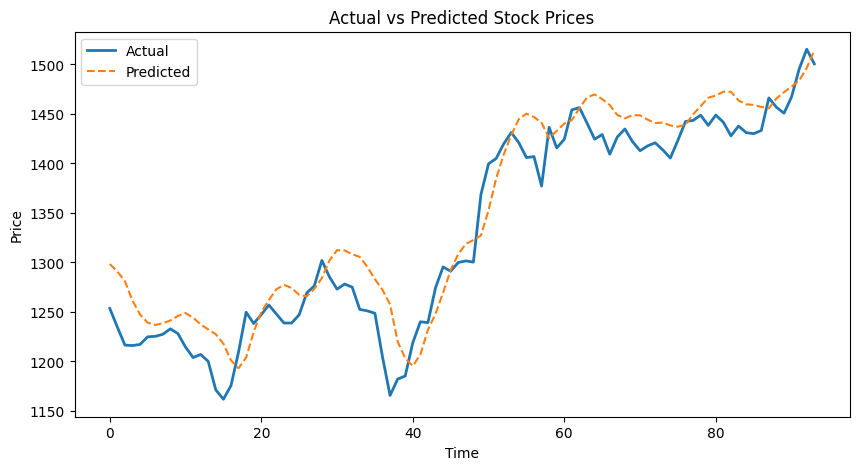

In [51]:
#plot actual vs predicted

y_pred = model.predict(X_test)

# Create dummy arrays for 'Open' and 'High' with the same shape as y_pred/y_test
dummy_open = np.zeros_like(y_pred)
dummy_high = np.zeros_like(y_pred)

# Combine predicted/actual 'Close' with dummy 'Open' and 'High'
y_pred_combined = np.hstack((dummy_open, dummy_high, y_pred))
y_test_combined = np.hstack((dummy_open, dummy_high, y_test.reshape(-1, 1)))

# Inverse transform the combined arrays
y_pred_inv = scaler.inverse_transform(y_pred_combined)[:, 2] # Extract the inverse transformed 'Close'
y_test_inv = scaler.inverse_transform(y_test_combined)[:, 2] # Extract the inverse transformed 'Close'

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
model.save('/content/drive/MyDrive/Colab_Stock/Reliance_model.keras')

import os
print(os.listdir('/content/drive/MyDrive/Colab_Stock'))

['Reliance.ipynb', 'RELIANCE_8y(17-25).csv', 'utils.py', 'Reliance_model.keras']


In [60]:
import joblib
joblib.dump(scaler, "/content/drive/MyDrive/Colab_Stock/scaler.save")

['/content/drive/MyDrive/Colab_Stock/scaler.save']

In [61]:
import json

metrics = {
    "val_loss": float(history.history['val_loss'][-1]),
    "val_mae": float(history.history['val_mae'][-1]),
    "train_loss": float(history.history['loss'][-1]),
    "train_mae": float(history.history['mae'][-1]),
    "epochs": len(history.history['loss']),
    "model_name": "Reliance_model.keras"
}

with open('/content/drive/MyDrive/Colab_Stock/model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
